<a href="https://colab.research.google.com/github/Zhang-Siyuan-Ella/Deep_learning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gather Data using APIs

In [ ]:
# data
# we will try to pull data for AMZN share price
# then we will try to predict the stock prices using vanilla RNN

In [ ]:
!pip install yfinance # uncomment it to download

In [ ]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# ticker of choice
tick = ['AAPL'] # you can add more or add ticker of choice such as IBM, AAPL, GOOG, GM etc.

# let us start with 2015
begin_period = '2020-01-01'
end_period = '2021-01-01'

In [ ]:
import yfinance as yf
# documentation: https://github.com/ranaroussi/yfinance

In [ ]:
data = yf.download(tick, start=begin_period, end=end_period)
data.head(4)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.796036,72.856628,71.545402,71.799888,135480400
2020-01-03,72.088295,72.851761,71.862892,72.020432,146322800
2020-01-06,72.662712,72.701492,70.954002,71.206070,118387200
2020-01-07,72.320992,72.929337,72.100433,72.672425,108872000


In [ ]:
data.tail(4)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-12-28,133.662994,134.298594,130.553408,131.022789,124486200
2020-12-29,131.883301,135.716491,131.365039,134.992887,121047300
2020-12-30,130.758759,132.978493,130.445838,132.577569,96452100
2020-12-31,129.751587,131.756193,128.803066,131.110805,99116600


## including all weekdays in the data

In [ ]:
# quantitative trading strategies often require all weekdays
# df = data.Close
# # let us get all the weekdays in the desired date range
# weekdays = pd.date_range(start= begin_period, end = end_period, freq='B')

# df = df.reindex(weekdays)
# df.head()

In [ ]:
# df = pd.DataFrame(df.fillna(method='bfill'))
# df = df.fillna(0)
# df.head()

In [ ]:
df = pd.DataFrame(data)
# get rownames as columns
df.index.name = 'Date'
df.reset_index(inplace=True)

In [ ]:
df.head(4)

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2020-01-02,72.796036,72.856628,71.545402,71.799888,135480400
1,2020-01-03,72.088295,72.851761,71.862892,72.020432,146322800
2,2020-01-06,72.662712,72.701492,70.954002,71.206070,118387200
3,2020-01-07,72.320992,72.929337,72.100433,72.672425,108872000


In [ ]:
print(df.columns)
print(df.dtypes)
print(df.describe)

MultiIndex([(  'Date',     ''),
            ( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Price   Ticker
Date              datetime64[ns]
Close   AAPL             float64
High    AAPL             float64
Low     AAPL             float64
Open    AAPL             float64
Volume  AAPL               int64
dtype: object
<bound method NDFrame.describe of Price        Date       Close        High         Low        Open     Volume
Ticker                   AAPL        AAPL        AAPL        AAPL       AAPL
0      2020-01-02   72.796036   72.856628   71.545402   71.799888  135480400
1      2020-01-03   72.088295   72.851761   71.862892   72.020432  146322800
2      2020-01-06   72.662712   72.701492   70.954002   71.206070  118387200
3      2020-01-07   72.320992   72.929337   72.100433   72.672425  108872000
4      2020-01-08   73.484337   73.787300   72

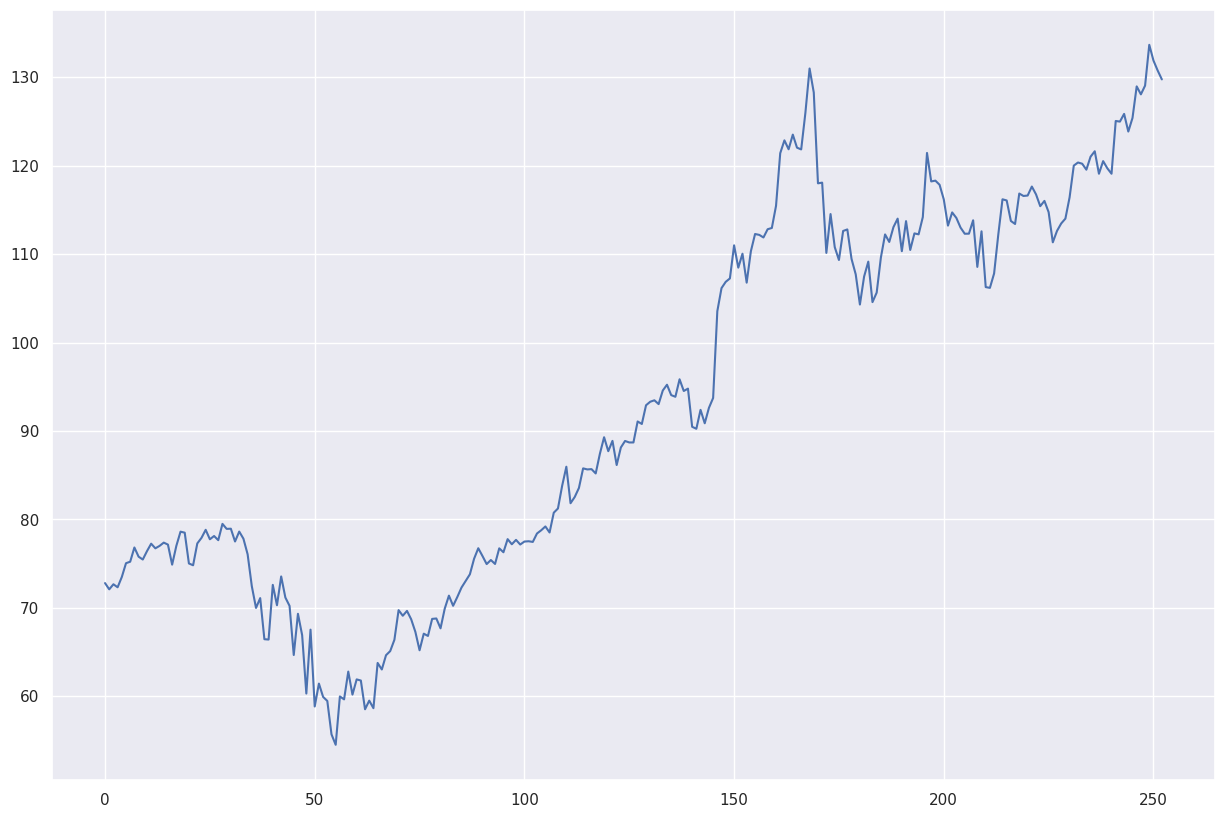

In [ ]:
# let us plot this data
# to do:pls complete the figure with adding lables to axes
sns.set_theme()
plt.figure(figsize= (15, 10))
plt.plot(df.Close)
#plt.xticks(range(0, df.shape[0], 100), df.Date.loc[::50], rotation=30)
# plt.plot(roll_mean, color='red')

plt.show()

# Data Prep

In [ ]:
# min max standardization
scale = MinMaxScaler(feature_range=(-1, 1))
# scale.fit_transform(df.Close.values) # gives error that 2D expected and got 1D
df['Close_norm'] = scale.fit_transform(df.Close.values.reshape(-1, 1))
df['Open_norm'] = scale.fit_transform(df.Open.values.reshape(-1, 1))
df['High_norm'] = scale.fit_transform(df.High.values.reshape(-1, 1))
df['Low_norm'] = scale.fit_transform(df.Low.values.reshape(-1, 1))

In [ ]:
def train_test_prep(series, x_variables, y_variables,  window_size, test_prop=0.2, validation_prop = 0.1):
  # series should be a numpy series
  x_series = series[x_variables].to_numpy()
  y_series = series[y_variables].to_numpy()
  x_data = []
  y_data = []
  for i in range(len(x_series) - window_size):
    x_data.append(x_series[i: i+window_size])
    y_data.append(y_series[i+window_size])
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  print(x_data[1])
  print(y_data[1])




  test_size = int(np.round(test_prop* x_data.shape[0]))
  validation_size = int(np.round(validation_prop* x_data.shape[0]))
  train_size = x_data.shape[0] - test_size - validation_size

  train_x = x_data[:train_size, :-1,:]
  train_y = y_data[:train_size, :]

  print("X:", train_x.shape)
  print("Y:", train_y.shape)

  validation_x = x_data[train_size:train_size+validation_size,:-1,:]
  validation_y = y_data[train_size:train_size+validation_size,:]

  test_x = x_data[train_size+validation_size:train_size+validation_size+test_size, :-1,:]
  test_y = y_data[train_size+validation_size:train_size+validation_size+test_size:, :]

  return [train_x, train_y, validation_x, validation_y, test_x, test_y]

In [ ]:
ws = 12

x_train, y_train, x_validation, y_validation, x_test, y_test = train_test_prep(df, ["Close_norm"], ["Close_norm"], ws)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('validation_x', x_validation.shape)#validation_x (2106, 11, 1)
print('validation_y', y_validation.shape)#validation_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

[[-0.55583522]
 [-0.54132117]
 [-0.54995557]
 [-0.52056081]
 [-0.48112149]
 [-0.47683494]
 [-0.43623164]
 [-0.46244311]
 [-0.47064917]
 [-0.44676527]
 [-0.42539247]
 [-0.43862013]]
[-0.43169969]
X: (169, 11, 1)
Y: (169, 1)
train_x (169, 11, 1)
train_y (169, 1)
validation_x (24, 11, 1)
validation_y (24, 1)
test_x (48, 11, 1)
test_y (48, 1)


In [ ]:
print(df["Close"][:18])

Ticker       AAPL
0       72.796036
1       72.088295
2       72.662712
3       72.320992
4       73.484337
5       75.045212
6       75.214859
7       76.821800
8       75.784439
9       75.459671
10      76.404915
11      77.250778
12      76.727272
13      77.001160
14      77.371986
15      77.148972
16      74.880394
17      76.998734


In [ ]:
y_train[:20]

array([[-0.43862013],
       [-0.43169969],
       [-0.42232985],
       [-0.42796486],
       [-0.48528602],
       [-0.43176099],
       [-0.39103605],
       [-0.39391458],
       [-0.48185635],
       [-0.48706167],
       [-0.42465742],
       [-0.40873475],
       [-0.38570794],
       [-0.41277937],
       [-0.40344866],
       [-0.41535774],
       [-0.3687653 ],
       [-0.38306846],
       [-0.38257765],
       [-0.4191026 ]])

In [ ]:
print(x_train[:3])

[[[-0.53795242]
  [-0.55583522]
  [-0.54132117]
  [-0.54995557]
  [-0.52056081]
  [-0.48112149]
  [-0.47683494]
  [-0.43623164]
  [-0.46244311]
  [-0.47064917]
  [-0.44676527]]

 [[-0.55583522]
  [-0.54132117]
  [-0.54995557]
  [-0.52056081]
  [-0.48112149]
  [-0.47683494]
  [-0.43623164]
  [-0.46244311]
  [-0.47064917]
  [-0.44676527]
  [-0.42539247]]

 [[-0.54132117]
  [-0.54995557]
  [-0.52056081]
  [-0.48112149]
  [-0.47683494]
  [-0.43623164]
  [-0.46244311]
  [-0.47064917]
  [-0.44676527]
  [-0.42539247]
  [-0.43862013]]]


In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
y_train.shape[0]
y_validation.shape[0]

24

In [ ]:
# base line model
from sklearn.metrics import mean_squared_error

#y_base_pred = np.array(df["Close"][ws-1:ws-1+y_train.shape[0]],dtype=np.float32)
#mse_loss_train = mean_squared_error(y_base_pred, np.squeeze(y_train))

y_base_test = np.array(df["Close"][ws+y_train.shape[0]+y_validation.shape[0]-1:-1],dtype=np.float32)
y_base_label = np.array(df["Close"][ws+y_train.shape[0]+y_validation.shape[0]:],dtype=np.float32)

print(y_base_test, y_base_label)
rmse_loss_test = np.sqrt(mean_squared_error(y_base_test, y_base_label))

print(rmse_loss_test)

[[112.99178 ]
 [112.29869 ]
 [112.30847 ]
 [113.82153 ]
 [108.550186]
 [112.57202 ]
 [106.26596 ]
 [106.17811 ]
 [107.80831 ]
 [112.210815]
 [116.193634]
 [116.0616  ]
 [113.7441  ]
 [113.40185 ]
 [116.84389 ]
 [116.5701  ]
 [116.61899 ]
 [117.63596 ]
 [116.74612 ]
 [115.41623 ]
 [116.01273 ]
 [114.74149 ]
 [111.32879 ]
 [112.61957 ]
 [113.46052 ]
 [114.0081  ]
 [116.41365 ]
 [120.002365]
 [120.354385]
 [120.2175  ]
 [119.54277 ]
 [121.00955 ]
 [121.62561 ]
 [119.08319 ]
 [120.51085 ]
 [119.699234]
 [119.08319 ]
 [125.0481  ]
 [124.979645]
 [125.84991 ]
 [123.85512 ]
 [125.39034 ]
 [128.95958 ]
 [128.0599  ]
 [129.04752 ]
 [133.663   ]
 [131.8833  ]
 [130.75876 ]] [[112.29869 ]
 [112.30847 ]
 [113.82153 ]
 [108.550186]
 [112.57202 ]
 [106.26596 ]
 [106.17811 ]
 [107.80831 ]
 [112.210815]
 [116.193634]
 [116.0616  ]
 [113.7441  ]
 [113.40185 ]
 [116.84389 ]
 [116.5701  ]
 [116.61899 ]
 [117.63596 ]
 [116.74612 ]
 [115.41623 ]
 [116.01273 ]
 [114.74149 ]
 [111.32879 ]
 [112.61957 ]
 [113

In [ ]:
#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test).type(torch.Tensor).cuda()
x_validation = torch.from_numpy(x_validation).type(torch.Tensor).cuda()
y_train = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test = torch.from_numpy(y_test).type(torch.Tensor).cuda()
y_validation = torch.from_numpy(y_validation).type(torch.Tensor).cuda()


In [ ]:
print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

print('validation_x', x_validation.shape)#test_x (902, 11, 1)
print('validation_y', y_validation.shape)#test_y (902, 1, 1)

train_x torch.Size([169, 11, 1])
train_y torch.Size([169, 1])
test_x torch.Size([48, 11, 1])
test_y torch.Size([48, 1])
validation_x torch.Size([24, 11, 1])
validation_y torch.Size([24, 1])


In [ ]:
print(x_train[20])

tensor([[-0.4819],
        [-0.4871],
        [-0.4247],
        [-0.4087],
        [-0.3857],
        [-0.4128],
        [-0.4034],
        [-0.4154],
        [-0.3688],
        [-0.3831],
        [-0.3826]], device='cuda:0')


In [ ]:
print(y_train[20])

tensor([-0.3907], device='cuda:0')


## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_dim = 1
hidden_dim = 50
num_layers = 5
output_dim = 1
num_epochs = 400

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.cuda()
cr = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time

train_hist = np.zeros(num_epochs)
validation_hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []


for t in range(num_epochs):
  model.train()
  y_train_pred = model(x_train)
  loss = cr(y_train_pred, y_train)
  train_hist[t] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad():
    y_validation_pred = model(x_validation)
    loss = cr(y_validation_pred, y_validation)
    validation_hist[t] = loss.item()
    print("Epoch ", t, "train MSE: ", train_hist[t], "validation MSE:", validation_hist[t])

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 train MSE:  0.2383771389722824 validation MSE: 0.614575207233429
Epoch  1 train MSE:  0.21253879368305206 validation MSE: 0.5492976903915405
Epoch  2 train MSE:  0.209642693400383 validation MSE: 0.5009064674377441
Epoch  3 train MSE:  0.20767071843147278 validation MSE: 0.4969799518585205
Epoch  4 train MSE:  0.1931132972240448 validation MSE: 0.43992874026298523
Epoch  5 train MSE:  0.15273010730743408 validation MSE: 0.190151184797287
Epoch  6 train MSE:  0.07214156538248062 validation MSE: 0.01610301248729229
Epoch  7 train MSE:  0.2307203859090805 validation MSE: 0.08727996051311493
Epoch  8 train MSE:  0.06030435487627983 validation MSE: 0.1452743113040924
Epoch  9 train MSE:  0.06616818159818649 validation MSE: 0.17293858528137207
Epoch  10 train MSE:  0.08076593279838562 validation MSE: 0.1700500249862671
Epoch  11 train MSE:  0.0941557064652443 validation MSE: 0.14661623537540436
Epoch  12 train MSE:  0.08789645880460739 validation MSE: 0.10869990289211273
Epoch  13 t

In [ ]:
predict = pd.DataFrame(scale.inverse_transform(y_train_pred.cpu().detach().numpy()))
original = pd.DataFrame(scale.inverse_transform(y_train.cpu().detach().numpy()))

[Text(-25.0, 0, ''),
 Text(0.0, 0, ''),
 Text(25.0, 0, ''),
 Text(50.0, 0, ''),
 Text(75.0, 0, ''),
 Text(100.0, 0, ''),
 Text(125.0, 0, ''),
 Text(150.0, 0, ''),
 Text(175.0, 0, ''),
 Text(200.0, 0, '')]

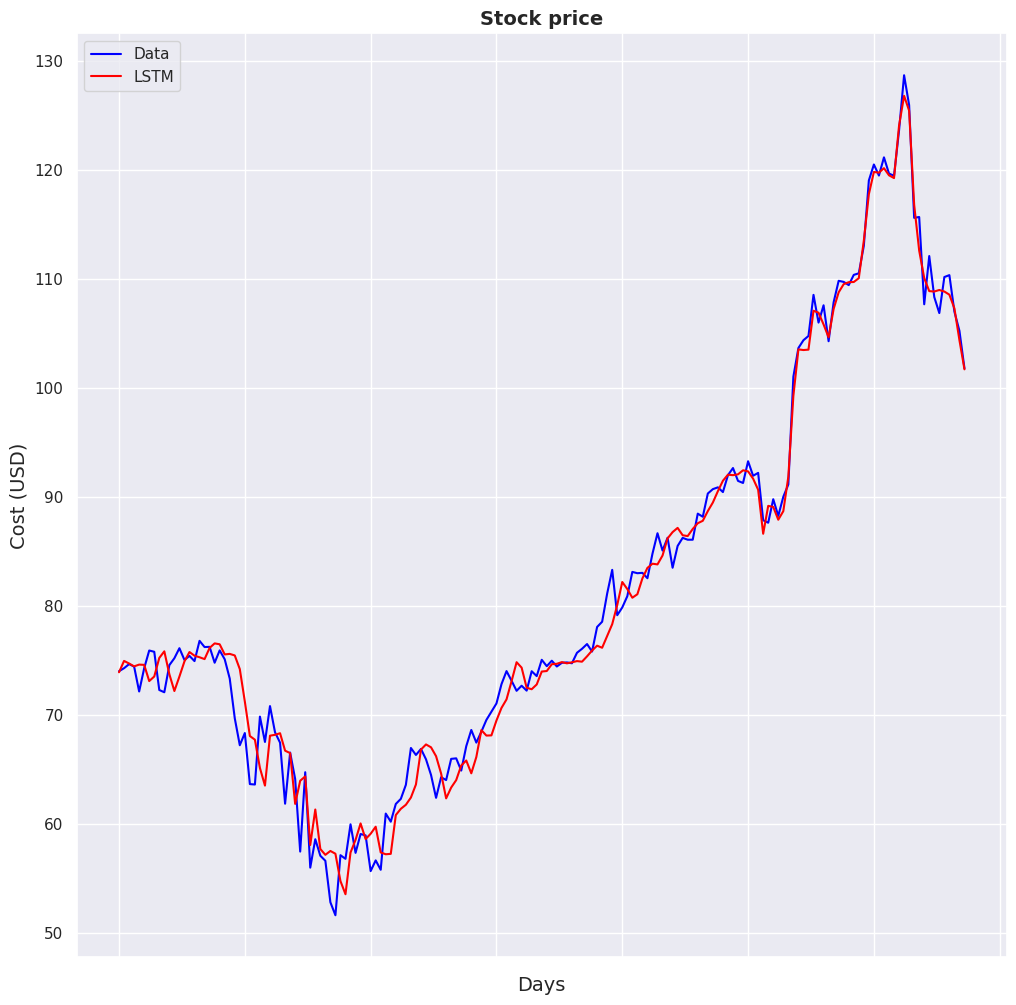

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="LSTM", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


#plt.subplot(1, 2, 2)
#ax = sns.lineplot(data=hist, color='royalblue')
#ax.set_xlabel("Epoch", size = 14)
#ax.set_ylabel("Loss", size = 14)
#ax.set_title("Training Loss", size = 14, fontweight='bold')
#fig.set_figheight(6)
#fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scale.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scale.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scale.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scale.inverse_transform(y_test.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 2.10 RMSE
Test Score: 9.68 RMSE


Tasks to do:
1. what's the baseline model ? Compare the performance of the baseline model with LSTM model;

2. How can we improve the performance of the model? More features; larger LSTM;

  2.1 To tune the parameters of LSTM;
  
  2.2 To add novel features as inputs;


the baseline model: a simple model that predicts the stock's closing price
based on the previous day's closing price


1.   RSME of Baseline model: 2.40
2.   RSME of LSTM: 2.10
*   The LSTM model performs better than the baseline model in predicting stock prices.




In [ ]:
# To tune the parameters of LSTM
# ticker of choice
tick = ['AAPL'] # you can add more or add ticker of choice such as IBM, AAPL, GOOG, GM etc.

# let us start with 2015
begin_period = '2020-01-01'
end_period = '2021-01-01'

import yfinance as yf
# documentation: https://github.com/ranaroussi/yfinance

data = yf.download(tick, start=begin_period, end=end_period)
data.head(4)
df = pd.DataFrame(data)

# min max standardization
scale = MinMaxScaler(feature_range=(-1, 1))
# scale.fit_transform(df.Close.values) # gives error that 2D expected and got 1D
df['Close_norm'] = scale.fit_transform(df.Close.values.reshape(-1, 1))
df['Open_norm'] = scale.fit_transform(df.Open.values.reshape(-1, 1))
df['High_norm'] = scale.fit_transform(df.High.values.reshape(-1, 1))
df['Low_norm'] = scale.fit_transform(df.Low.values.reshape(-1, 1))
def train_test_prep(series, x_variables, y_variables,  window_size, test_prop=0.2, validation_prop = 0.1):
  # series should be a numpy series
  x_series = series[x_variables].to_numpy()
  y_series = series[y_variables].to_numpy()
  x_data = []
  y_data = []
  for i in range(len(x_series) - window_size):
    x_data.append(x_series[i: i+window_size])
    y_data.append(y_series[i+window_size])
  x_data = np.array(x_data)
  y_data = np.array(y_data)


  test_size = int(np.round(test_prop* x_data.shape[0]))
  validation_size = int(np.round(validation_prop* x_data.shape[0]))
  train_size = x_data.shape[0] - test_size - validation_size

  train_x = x_data[:train_size, :-1,:]
  train_y = y_data[:train_size, :]

  print("X:", train_x.shape)
  print("Y:", train_y.shape)

  validation_x = x_data[train_size:train_size+validation_size,:-1,:]
  validation_y = y_data[train_size:train_size+validation_size,:]

  test_x = x_data[train_size+validation_size:train_size+validation_size+test_size, :-1,:]
  test_y = y_data[train_size+validation_size:train_size+validation_size+test_size:, :]

  return [train_x, train_y, validation_x, validation_y, test_x, test_y]
ws = 12

x_train, y_train, x_validation, y_validation, x_test, y_test = train_test_prep(df, ["Close_norm"], ["Close_norm"], ws)


#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test).type(torch.Tensor).cuda()
x_validation = torch.from_numpy(x_validation).type(torch.Tensor).cuda()
y_train = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test = torch.from_numpy(y_test).type(torch.Tensor).cuda()
y_validation = torch.from_numpy(y_validation).type(torch.Tensor).cuda()

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
#1 15 2 1 200 0.001
input_dim = 1
hidden_dim = 15
num_layers = 2
output_dim = 1
num_epochs = 200

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.cuda()
cr = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
import time

train_hist = np.zeros(num_epochs)
validation_hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []


for t in range(num_epochs):
  model.train()
  y_train_pred = model(x_train)
  loss = cr(y_train_pred, y_train)
  train_hist[t] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad():
    y_validation_pred = model(x_validation)
    loss = cr(y_validation_pred, y_validation)
    validation_hist[t] = loss.item()
    print("Epoch ", t, "train MSE: ", train_hist[t], "validation MSE:", validation_hist[t])

training_time = time.time()-start_time
print("Training time: {}".format(training_time))
predict = pd.DataFrame(scale.inverse_transform(y_train_pred.cpu().detach().numpy()))
original = pd.DataFrame(scale.inverse_transform(y_train.cpu().detach().numpy()))


[*********************100%***********************]  1 of 1 completed


X: (169, 11, 1)
Y: (169, 1)
Epoch  0 train MSE:  0.2529742121696472 validation MSE: 0.3036257028579712
Epoch  1 train MSE:  0.25016292929649353 validation MSE: 0.30899888277053833
Epoch  2 train MSE:  0.24743227660655975 validation MSE: 0.3144652545452118
Epoch  3 train MSE:  0.24477477371692657 validation MSE: 0.3200552463531494
Epoch  4 train MSE:  0.242179736495018 validation MSE: 0.3257651627063751
Epoch  5 train MSE:  0.2396394908428192 validation MSE: 0.3315887153148651
Epoch  6 train MSE:  0.23714883625507355 validation MSE: 0.337526798248291
Epoch  7 train MSE:  0.23470313847064972 validation MSE: 0.34358546137809753
Epoch  8 train MSE:  0.2322978675365448 validation MSE: 0.34977251291275024
Epoch  9 train MSE:  0.22992877662181854 validation MSE: 0.35609567165374756
Epoch  10 train MSE:  0.22759245336055756 validation MSE: 0.36256182193756104
Epoch  11 train MSE:  0.2252863198518753 validation MSE: 0.3691769540309906
Epoch  12 train MSE:  0.22300873696804047 validation MSE: 0.

[Text(-25.0, 0, ''),
 Text(0.0, 0, ''),
 Text(25.0, 0, ''),
 Text(50.0, 0, ''),
 Text(75.0, 0, ''),
 Text(100.0, 0, ''),
 Text(125.0, 0, ''),
 Text(150.0, 0, ''),
 Text(175.0, 0, ''),
 Text(200.0, 0, '')]

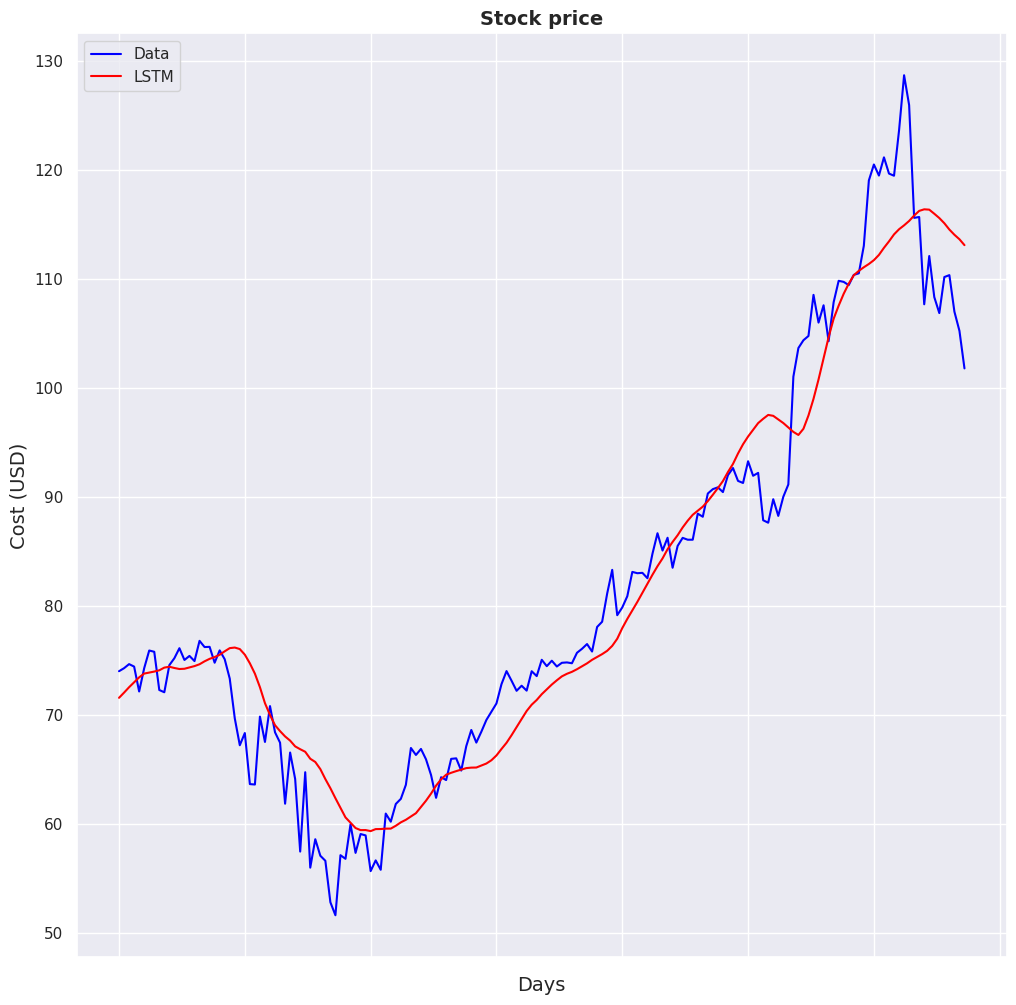

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="LSTM", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


#plt.subplot(1, 2, 2)
#ax = sns.lineplot(data=hist, color='royalblue')
#ax.set_xlabel("Epoch", size = 14)
#ax.set_ylabel("Loss", size = 14)
#ax.set_title("Training Loss", size = 14, fontweight='bold')
#fig.set_figheight(6)
#fig.set_figwidth(16)




In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scale.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scale.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scale.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scale.inverse_transform(y_test.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 4.74 RMSE
Test Score: 6.03 RMSE


In [ ]:
#To add novel features as inputs
# To tune the parameters of LSTM
# ticker of choice
tick = ['AAPL'] # you can add more or add ticker of choice such as IBM, AAPL, GOOG, GM etc.

# let us start with 2015
begin_period = '2020-01-01'
end_period = '2021-01-01'

import yfinance as yf
# documentation: https://github.com/ranaroussi/yfinance

data = yf.download(tick, start=begin_period, end=end_period)
df = pd.DataFrame(data)

# min max standardization
scale = MinMaxScaler(feature_range=(-1, 1))
# scale.fit_transform(df.Close.values) # gives error that 2D expected and got 1D
df['Close_norm'] = scale.fit_transform(df.Close.values.reshape(-1, 1))
df['Open_norm'] = scale.fit_transform(df.Open.values.reshape(-1, 1))
df['High_norm'] = scale.fit_transform(df.High.values.reshape(-1, 1))
df['Low_norm'] = scale.fit_transform(df.Low.values.reshape(-1, 1))
def train_test_prep(series, x_variables, y_variables,  window_size, test_prop=0.2, validation_prop = 0.1):
  # series should be a numpy series
  x_series = series[x_variables].to_numpy()
  y_series = series[y_variables].to_numpy()
  x_data = []
  y_data = []
  for i in range(len(x_series) - window_size):
    x_data.append(x_series[i: i+window_size])
    y_data.append(y_series[i+window_size])
  x_data = np.array(x_data)
  y_data = np.array(y_data)


  test_size = int(np.round(test_prop* x_data.shape[0]))
  validation_size = int(np.round(validation_prop* x_data.shape[0]))
  train_size = x_data.shape[0] - test_size - validation_size

  train_x = x_data[:train_size, :-1,:]
  train_y = y_data[:train_size, :]

  print("X:", train_x.shape)
  print("Y:", train_y.shape)

  validation_x = x_data[train_size:train_size+validation_size,:-1,:]
  validation_y = y_data[train_size:train_size+validation_size,:]

  test_x = x_data[train_size+validation_size:train_size+validation_size+test_size, :-1,:]
  test_y = y_data[train_size+validation_size:train_size+validation_size+test_size:, :]

  return [train_x, train_y, validation_x, validation_y, test_x, test_y]
ws = 12
#df['Open_norm']
x_train, y_train, x_validation, y_validation, x_test, y_test = train_test_prep(df, ["Close_norm",'Open_norm'], ["Close_norm"], ws)


#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test).type(torch.Tensor).cuda()
x_validation = torch.from_numpy(x_validation).type(torch.Tensor).cuda()
y_train = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test = torch.from_numpy(y_test).type(torch.Tensor).cuda()
y_validation = torch.from_numpy(y_validation).type(torch.Tensor).cuda()

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
#1 15 2 1 200 0.001
input_dim = 2
hidden_dim = 15
num_layers = 2
output_dim = 1
num_epochs = 200

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.cuda()
cr = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
import time

train_hist = np.zeros(num_epochs)
validation_hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []


for t in range(num_epochs):
  model.train()
  y_train_pred = model(x_train)
  loss = cr(y_train_pred, y_train)
  train_hist[t] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad():
    y_validation_pred = model(x_validation)
    loss = cr(y_validation_pred, y_validation)
    validation_hist[t] = loss.item()
    print("Epoch ", t, "train MSE: ", train_hist[t], "validation MSE:", validation_hist[t])

training_time = time.time()-start_time
print("Training time: {}".format(training_time))
predict = pd.DataFrame(scale.inverse_transform(y_train_pred.cpu().detach().numpy()))
original = pd.DataFrame(scale.inverse_transform(y_train.cpu().detach().numpy()))


[*********************100%***********************]  1 of 1 completed


X: (169, 11, 2)
Y: (169, 1)
Epoch  0 train MSE:  0.5750744342803955 validation MSE: 0.031363554298877716
Epoch  1 train MSE:  0.561963677406311 validation MSE: 0.03367794677615166
Epoch  2 train MSE:  0.5493612289428711 validation MSE: 0.03606647998094559
Epoch  3 train MSE:  0.5372480154037476 validation MSE: 0.038523510098457336
Epoch  4 train MSE:  0.5256031155586243 validation MSE: 0.04104435443878174
Epoch  5 train MSE:  0.5144034624099731 validation MSE: 0.0436253547668457
Epoch  6 train MSE:  0.5036237835884094 validation MSE: 0.04626370593905449
Epoch  7 train MSE:  0.49323856830596924 validation MSE: 0.048957400023937225
Epoch  8 train MSE:  0.483222097158432 validation MSE: 0.05170532315969467
Epoch  9 train MSE:  0.473548948764801 validation MSE: 0.054507166147232056
Epoch  10 train MSE:  0.4641932249069214 validation MSE: 0.05736334249377251
Epoch  11 train MSE:  0.4551292359828949 validation MSE: 0.06027480959892273
Epoch  12 train MSE:  0.44633129239082336 validation MSE:

[Text(-25.0, 0, ''),
 Text(0.0, 0, ''),
 Text(25.0, 0, ''),
 Text(50.0, 0, ''),
 Text(75.0, 0, ''),
 Text(100.0, 0, ''),
 Text(125.0, 0, ''),
 Text(150.0, 0, ''),
 Text(175.0, 0, ''),
 Text(200.0, 0, '')]

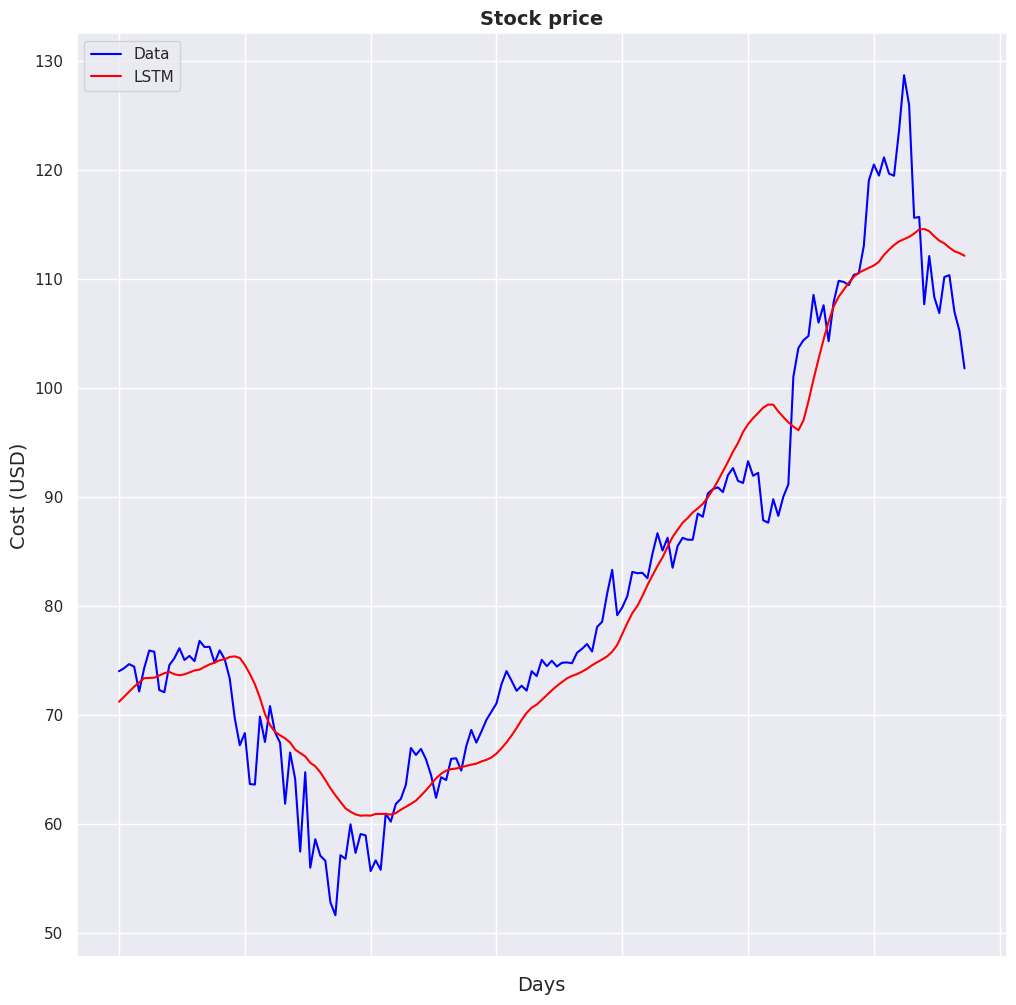

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="LSTM", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


#plt.subplot(1, 2, 2)
#ax = sns.lineplot(data=hist, color='royalblue')
#ax.set_xlabel("Epoch", size = 14)
#ax.set_ylabel("Loss", size = 14)
#ax.set_title("Training Loss", size = 14, fontweight='bold')
#fig.set_figheight(6)
#fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scale.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scale.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scale.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scale.inverse_transform(y_test.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 4.71 RMSE
Test Score: 6.83 RMSE
